# Automated Predictions of Disease Classification Within Dermoscopic Images
by [Lei You](https://www.linkedin.com/in/lei-you-462b8045/)

## Table of Content
* [1 Summary of the Notebook](#section_1) <br>
* [2 Preparation for Running the Notebook](#section_2) <br>
* [3 Pre-analysis on Dataset](#section_3) <br>
    + [3.1 Filling the Null Values](#section_3.1) <br>
    + [3.2 Inspecting the Dataset with Random Sampling](#section_3.2) <br>
    + [3.3 Distribution of the Dataset](#section_3.3) <br>
* [4 Data Augmentation](#section_4) <br>
    + [4.1 Image Transformation to Reproduce Variations](#section_4.1) <br>
    + [4.2 Applying Image Transformation to Data Augmentation](#section_4.2) <br>
* [5 Modeling](#section_5) <br>
    + [5.1 Model Selection](#section_5.1) <br>
    + [5.2 Model Configuration](#section_5.2) <br>
    + [5.3 Loading Data to Model](#section_5.3) <br>
    + [5.4 Model Creation](#section_5.4) <br>
* [6 Model Training](#section_6) <br>
* [7 Performance Analysis](#section_7) <br>
    + [7.1 Accuracy (which is not a good measurement for this problem)](#section_7.1) <br>
    + [7.2 F1-Score](#section_7.2) <br>
    + [7.3 Cross Entropy Loss](#section_7.3) <br>
    + [7.4 Confusion Matrix (Train)](#section_7.4) <br>
    + [7.5 Confusion Matrix (Validation)](#section_7.5) <br>
* [8 Conclusion and Findings](#section_8) <br>

<a id='section_1'></a>

## 1 Summary of the Notebook
---
This notebook addresses the automated predictions of lesion diagnosis problem. The dataset is [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). 

By analysis on the provided code as well as the dataset, we found **some key issues**. They are listed below.
- The dataset is highly imbalanced. 
- The train_test_split function in the provided code is not correct.
- Because of the imbalance of the dataset, class weights (which is used for computing the loss function) need to be set properly. 
- For a deep learning problem, a dataset consists of 10,000 samples is not large, making a model to be overfitted easily.
- Accuracy is not a good metric for evaluating the model performance. This issue will be discussed later on.

To address the lesion diagnosis problem. **Our approach** is summarized as follows.
1. We replace the random sampler with a **weighted random sampler** so as to deal with the imbalance of the samples in the dataset. In the original code the weights are set to be 1.0 for all classes, which does not deal against the dataset imbalance. Our weights are calculated based on the distribution of each classs in the dataset.
2. The original train_test_split function is incorrect, as it doesn't do **shuffling on the dataset** before splitting. The issue is fixed in our code.
3. We implemented **data augmentation** so as to alleviate the overfitting problem. The data augmentation functionality is implemented by a overridden method of the 'getitem' function in the class HAM10000. The overridden one gives a picture with some added noise (e.g. flipping, saturation, and Gaussian blur etc.) once it is called.
4. Because the HAM10000 dataset is not large, we propose to use **transfer learning**. Meanwhile, the **data augmentation** could yield a larger dataset for us to train the model.
5. Besides the provided convolutional neural network, i.e., 'SimpleCNN', we have tried **several other models**. Not all of them are successful due to our limit of available computational resource. The results can be found in the corresponding folders in 'experiment/'.
6. We implemented metrics other than the accuracy for model performance evaluation. Specifically, we propose to use **f1-score** along with the **confusion matrix** (with and without normalization) for justifying how good is our trained classifier.

<a id='section_2'></a>

## 2 Preparation for Running the Notebook
---
(<font color='red'>**Warning:**</font> Some packages would be installed by executing this section)

This project is done with Colab by the author. In the next section we provide the code for mounting your Google Drive to Colab. 

In [530]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB == True:
    # Load the Drive helper and mount

    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

    # After executing the cell above, Drive
    # files will be present in "/content/drive/My Drive".
    !ls "/content/drive/My Drive"

    # We impose the working_folder path

If *IN_COLAB==True*, the variable *working_folder* should be set to the path of the notebook in your Google Drive. And we change the working folder to be the one for the project. Otherwise it is set to be the current folder of the notebook. 

In [531]:
if IN_COLAB == True:
    import os
    working_folder = '/content/drive/My Drive/Colab Notebooks/Peltarion/'
    os.chdir(working_folder)
else:
    working_folder = './'

In [532]:
data_folder = working_folder + 'data/'

In addition, we use the third party library 'imgaug' for doing data augmentation. 

(<font color='red'>**Warning:**</font> The command below will install imgaug with the command pip.)

In [566]:
!pip install git+https://github.com/aleju/imgaug

<a id='section_3'></a>

## 3 Pre-analysis on Dataset
---
We read the dataset by using the modules in folder 'lib'. Before doing training, we do anlaysis on the dataset to see if it is balanced or not.

In [533]:
from lib.dataset import *
from lib.utils import *

In [534]:
data_folder = working_folder + 'data/'
meta_data = read_meta_data(data_folder)

<a id='section_3.1'></a>

### 3.1 Filling the Null Values

We check if there is null value in columns.

In [535]:
meta_data.isnull().sum()

lesion_id        0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

The null values are replaced by mean, after which we check it again.

In [536]:
meta_data['age'].fillna((meta_data['age'].mean()), inplace=True)
meta_data.isnull().sum()

lesion_id       0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

<a id='section_3.2'></a>

### 3.2 Inspecting the Dataset with Random Sampling

We create a column showing the name of each cell. 

In [537]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
meta_data['cell_type'] = meta_data['dx'].map(lesion_type_dict.get) 

The following code randomly samples five rows from the meta dataset and show respectively the information of them along with their corresponding images.

,lesion_id,dx,dx_type,age,sex,localization,cell_type
image_id,,,,,,,
ISIC_0028939,HAM_0005218,nv,follow_up,55.0,female,lower extremity,Melanocytic nevi
ISIC_0033989,HAM_0007444,nv,histo,50.0,female,lower extremity,Melanocytic nevi
ISIC_0032280,HAM_0002839,bkl,histo,60.0,female,lower extremity,Benign keratosis-like lesions
ISIC_0030863,HAM_0005070,nv,follow_up,55.0,female,trunk,Melanocytic nevi
ISIC_0028257,HAM_0005969,nv,follow_up,35.0,male,abdomen,Melanocytic nevi


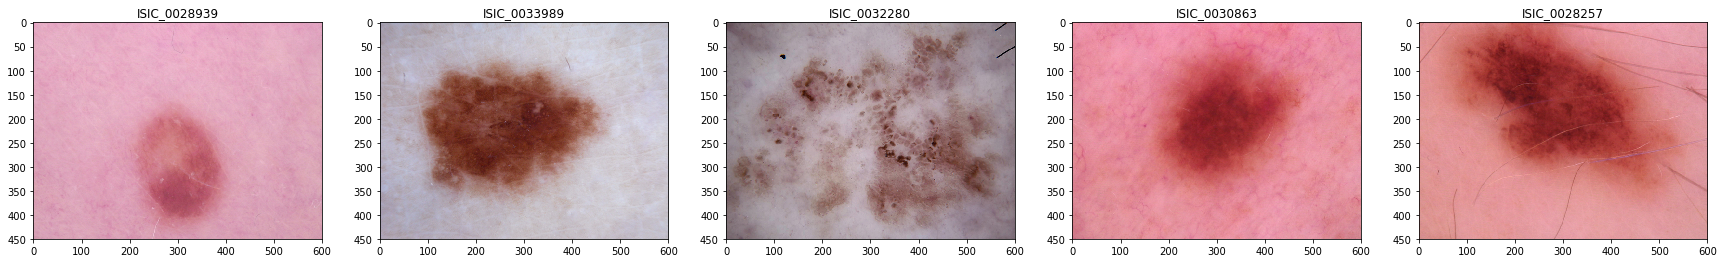

In [538]:
from IPython.display import display
sampled_meta_data = meta_data.sample(5)
image_id_list = list(sampled_meta_data.index)
display(sampled_meta_data)

from PIL import Image
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow

img_list = []
for image_id in image_id_list:
    img = np.asarray(Image.open(data_folder + image_id + '.jpg'))
    img_list.append(img)

show_images(np.array(img_list), titles = image_id_list)

We know that there are 7 types of cells in the dataset. They are:

In [539]:
pd.DataFrame(list(lesion_type_dict.values()),columns = ['Cell Type'],index=range(1,8))

,Cell Type
1,Melanocytic nevi
2,Melanoma
3,Benign keratosis-like lesions
4,Basal cell carcinoma
5,Actinic keratoses
6,Vascular lesions
7,Dermatofibroma


<a id='section_3.3'></a>

### 3.3 Distribution of the Dataset

Now we insepct the **distribution of these 7 classes** in the dataset.

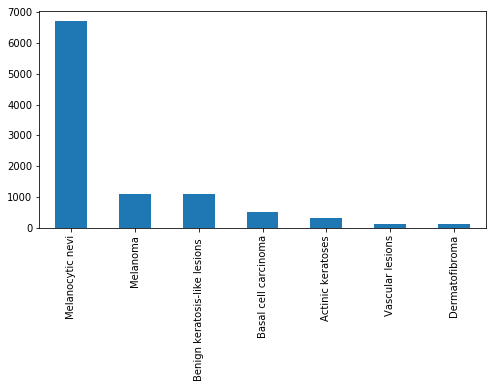

In [540]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, figsize= (8, 4))
meta_data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

We see that the dataset is highly imbalanced. To be specific, in the dataset, 'Melanecytic nevi' has very large number of instances in comparison to others. 

In [541]:
# Accuracy by estimating every cell to be 'Melanecytic nevi'
num_mv = meta_data['cell_type'].value_counts()['Melanocytic nevi']
baseline_acc = num_mv / len(meta_data)
baseline_acc

0.66949575636545178

This result also implies that **accuracy is not a good measurement** for this problem. As shown above, **if a classifier predicts every cell to be 'Melanecytic nevi', then one can reach the accuracy 67%**.

<a id='section_4'></a>

## 4 Data Augmentation
---

To avoid overfitting problem, we choose to do data augmentation on the dataset HAM10000. The idea behind image data augmentation is to introduce some noise to the original images in the training set, such as image rotation, Guassian blurring, hue/saturation adjustment etc. Below we give detailed explanation for how it is done in this notebook.

The image data augmentation is based on the third party library imgaug (which is installed in the '*Preparation for Running the Notebook*' section in this notebook). All the functions and class for the data augmentation are defined in the python file '*lib/dataset.py*'.

In [542]:
from lib.dataset import *

<a id='section_4.1'></a>

### 4.1 Image Transformation to Reproduce Variations
The idea behind our data augmentation is to do some small transformation on images, so as to reproduce some variations across the training dataset. We first show the effect of the transformation method used in this notebook. 

Still, we do some random sampling on the dataset for demonstration.

In [543]:
sampled_meta_data = meta_data.sample(5)
image_id_list = list(sampled_meta_data.index)
display(sampled_meta_data)

,lesion_id,dx,dx_type,age,sex,localization,cell_type
image_id,,,,,,,
ISIC_0024919,HAM_0006349,nv,follow_up,50.0,female,trunk,Melanocytic nevi
ISIC_0027864,HAM_0000944,nv,follow_up,75.0,male,upper extremity,Melanocytic nevi
ISIC_0026220,HAM_0005042,nv,follow_up,60.0,female,lower extremity,Melanocytic nevi
ISIC_0033789,HAM_0006182,nv,histo,35.0,male,abdomen,Melanocytic nevi
ISIC_0031783,HAM_0002357,bkl,histo,70.0,male,neck,Benign keratosis-like lesions


The images **before transformation** looks like below.

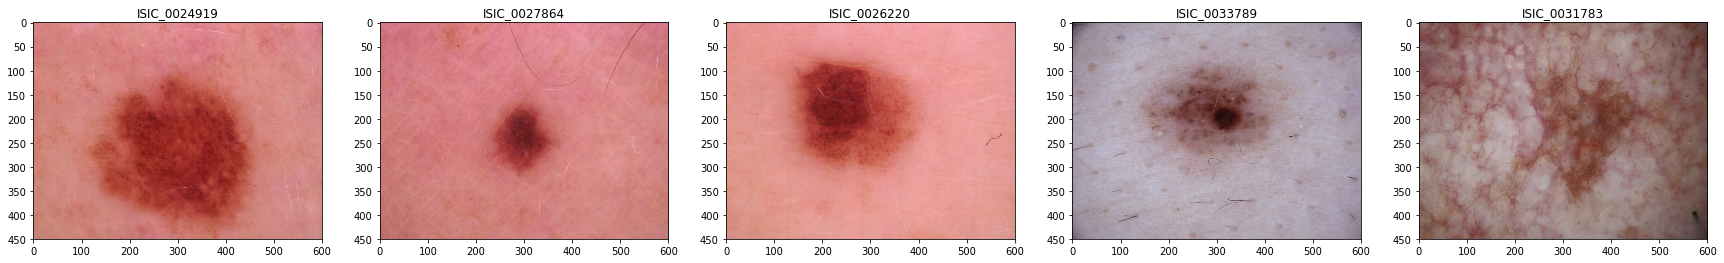

In [544]:
img_list = []
for image_id in image_id_list:
    img = np.asarray(Image.open(data_folder + image_id + '.jpg'))
    img_list.append(img)

show_images(np.array(img_list), titles = image_id_list)

Then we show images **after transformation** by using the class '*ImgAugTransform* defined in '*lib/dataset.py*. Once an object is instantiated from this class, parameters are randomly chosen for image rotation, Guassian blurring, hue/saturation adjustment etc. Calling the method '*process*' towards the image would yield the transformed one.

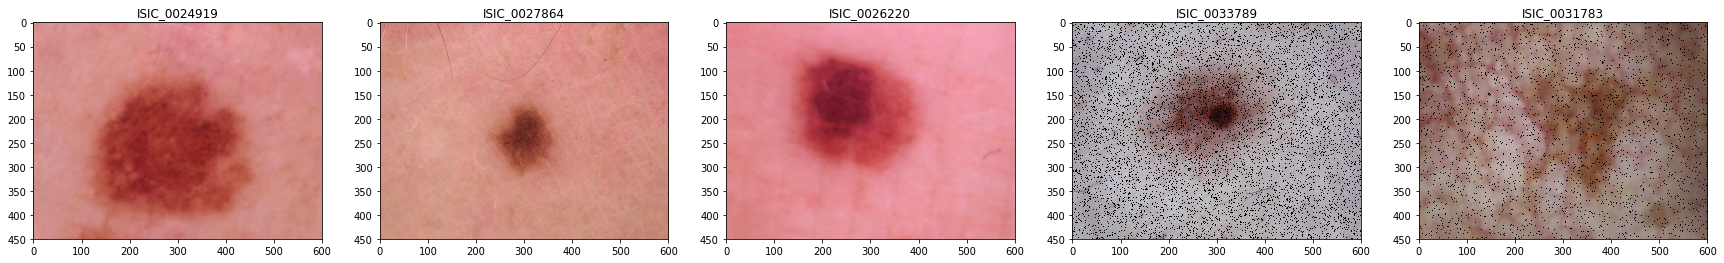

In [545]:
img_trans_list = []
for img in img_list:
    img_trans = ImgAugTransform().process(img) # see below for the definition
    img_trans_list.append(img_trans)
    
show_images(np.array(img_trans_list), titles = image_id_list)

The class 'ImgAugTransform' is shown below.
```python
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])
      
    def process(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)
```

<a id='section_4.2'></a>

### 4.2 Applying Image Transformation to Data Augmentation
In order to apply the image transformation demonstrated above to the data augmentation. We choose to define a new class for dataset, with the '\_\_getitem\_\_' method overridden.
```python
class HAM10000_aug(HAM10000):
    def __getitem__(self, index):
        image_id = self.sampling_list[index]
        img = Image.open(self.image_paths_dict.get(image_id))
        assert(image_id in self.meta_data.index)
        label = self.class_map_dict[self.meta_data.loc[image_id]['dx']]

        img = ImgAugTransform().process(img)
        img = transforms.ToTensor()(img)

        return img, label
```
For example, if we instantiate an object from HAM10000_aug, e.g. 
```python
dataset = HAM10000_aug(...)
```
Then calling 
```python
dataset.__getitem__(i) 
```
gives us the $i_{th}$ item in the dataset with random transformation imposed on it. 

Even though we have roughly 10000 samples in total, by using the newly defined class, we may generate much more "different" samples.

<a id='section_5'></a>

## 5 Modeling
---

<a id='section_5.1'></a>

### 5.1 Model Selection

In this section, we define and select the deep learning model for problem solving. The candidate models are listed as follows. Due to the limitation of our computational resource, the model that we tested mostly frequently is '*SimpleCNN*'. 

**Remark:** To change switch the model, just change '*selected_model*' here to be your desired one in the '*model_names*' list.

In [546]:
model_names = ['SimpleCNN', 'SimpleCNN_dropout', 'ResNet50', 'CNN', 'DenseNet201', 'VGG16']
selected_model = 'SimpleCNN_dropout'

Below we import the required libraries for training and visulization.

In [547]:
import argparse
import matplotlib
matplotlib.use('agg')
import torch.optim as optim
from torch.utils.data.sampler import RandomSampler
from torch.utils.data.sampler import WeightedRandomSampler

import torch.backends.cudnn as cudnn
from sklearn.metrics import f1_score

from lib.dataset import *
from lib.utils import *

from networks.SimpleCNN import *
from networks.SimpleCNN_dropout import *
from networks.CNN import *
import torchvision.models as models

<a id='section_5.2'></a>

### 5.2 Model Configuration

In [549]:
# Parse args.
parser = argparse.ArgumentParser(description='PyTorch classifier on HAM10000 dataset')
parser.add_argument('--data-dir', default='./data', help='path to data')
parser.add_argument('--train_fraction', default=0.2, type=float,
                    help='fraction of dataset to use for training')
parser.add_argument('--val_fraction', default=0.2, type=float,
                    help='fraction of dataset to use for validation')
parser.add_argument('--exp-name', default=selected_model, choices=model_names, type=str,
                    help='name of experiment')
parser.add_argument('--log-level', default='INFO', choices=['DEBUG', 'INFO'],
                    help='log-level to use')
parser.add_argument('--batch-size', default=10, type=int,
                    help='batch-size to use')
parser.add_argument('--network', default=selected_model, choices=model_names,
                    help='network architecture')
parser.add_argument('--num-epochs', default=100, type=int,
                    help='Number of training epochs')
args = parser.parse_args(args=[])


# Globals.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

# Logging.
LOGGER = logging.getLogger(__name__)
exp_dir = os.path.join('experiments', '{}'.format(args.exp_name))
log_file = os.path.join(exp_dir, 'log.log')
npy_file = os.path.join(exp_dir, 'final_results.npy')
os.makedirs(exp_dir, exist_ok=True)
setup_logging(log_path=log_file, log_level=args.log_level, logger=LOGGER)
args_file = os.path.join(exp_dir, 'args.log')
with open(args_file, 'w') as the_file:
    the_file.write(str(args))
STATUS_MSG = "Batches done: {}/{} | Loss: {:04f} | Accuracy: {:04f} | F1: {:04f}"
STATUS_MSG_EPOCH = "Epoch {} done: | Loss: {:04f} | Accuracy: {:04f} | F1: {:04f}"

2019-04-15 21:45:38,726 INFO  __main__        - Log file is experiments/SimpleCNN_dropout/log.log


<a id='section_5.3'></a>

### 5.3 Loading Data to Model

We create the dataset by using the two classes '*HAM10000*' and '*HAM10000_aug*', respectively for validation set and training set.

In [551]:
# Initialize datasets and loaders.
LOGGER.info('==> Preparing data..')
train_ids, val_ids = create_train_val_split(args.data_dir,
                                            args.train_fraction,
                                            args.val_fraction)
train_set = HAM10000_aug(args.data_dir, train_ids)
val_set = HAM10000(args.data_dir, val_ids)

num_classes = train_set.get_num_classes()

2019-04-15 21:45:48,229 INFO  __main__        - ==> Preparing data..


We remark that in the original code, the data set splitting is not implemented correctly. The **old code** is as below:
```python
def create_train_val_split(data_dir, train_fraction, val_fraction):
    assert(train_fraction + val_fraction <= 1.0)
    meta_data = read_meta_data(data_dir)
    image_ids = meta_data.index.tolist()
    num_images = len(image_ids)
    num_train_ids = int(num_images * train_fraction)
    num_val_ids = int(num_images * val_fraction)
    train_ids = image_ids[:num_train_ids]
    val_ids = image_ids[-num_val_ids:]
    return train_ids, val_ids
```

In the old code, the dataset is not shuffled before splitting, which means that the training data is always selected from the top end of the data sheet, and validation set the bottom end of the sheet. 

We illustrate the issue as follows. Suppose the fraction for training set and validation set is $0.1$. Then the distribution of the training set is below.

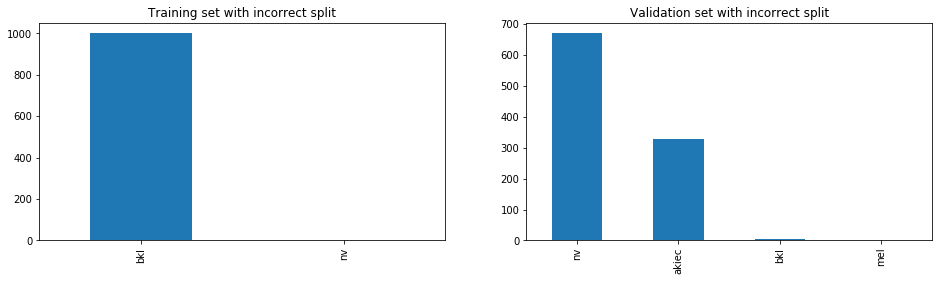

In [552]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16, 4))
meta_data[:int(len(meta_data)*0.1)]['dx'].value_counts().plot(kind='bar', ax=ax1, title='Training set with incorrect split')
meta_data[-int(len(meta_data)*0.1):]['dx'].value_counts().plot(kind='bar', ax=ax2, title='Validation set with incorrect split')

And that is the reason that the old code always yields zero accuracy on the validation set, regardless of how long time the model is trained. To fix this issue, we have rewritten the function for dataset split. The **new function** is as follows.
```python
def create_train_val_split(data_dir, train_fraction, val_fraction, random_seed = 42):
    assert(train_fraction + val_fraction <= 1.0)
    meta_data = read_meta_data(data_dir)
    image_ids = meta_data.index.tolist()
    num_images = len(image_ids)
    split_train = int(np.floor(train_fraction * num_images))
    split_valid = int(np.ceil(val_fraction * num_images))
    np.random.seed(random_seed)
    np.random.shuffle(image_ids)
    train_ids, valid_ids = image_ids[:split_train], image_ids[-split_valid:]
    return train_ids, valid_ids
```
And the new function gives us the dataset distribution as follows.

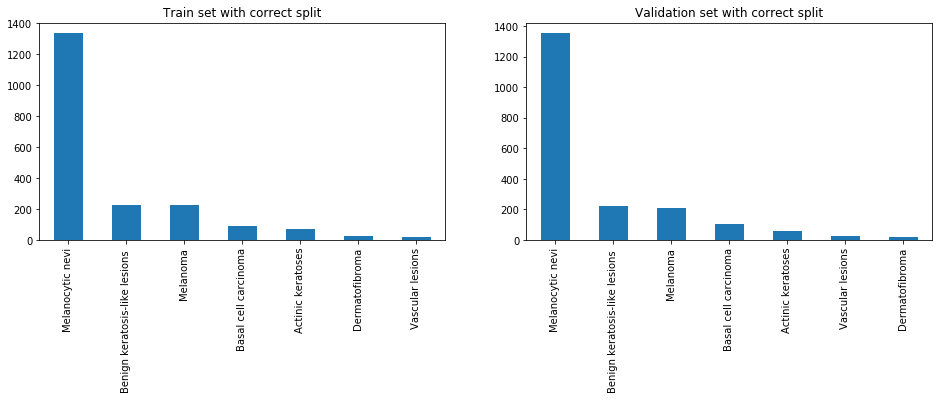

In [553]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16, 4))
pd.DataFrame(train_set.get_labels()).replace(lesion_type_dict)[0].value_counts().plot(kind='bar', ax=ax1,title='Train set with correct split')
pd.DataFrame(val_set.get_labels()).replace(lesion_type_dict)[0].value_counts().plot(kind='bar', ax=ax2,title='Validation set with correct split')

Since the dataset is **highly imbalanced**, instead of using a uniform randome sampler, we choose to use a **weighted sampler**:

In [554]:
sampler_weights = make_weights_for_balanced_classes(train_set,num_classes)

train_sampler = WeightedRandomSampler(weights = sampler_weights,
                                      num_samples=len(train_set))

The weight for any specific class $i$ ($i\in\{0,1,\ldots,6\}$) is calculated based on the formula below.

\begin{equation}
w_i = \frac{\text{Total number of samples}}{\text{Counts of samples belong to class }i}
\end{equation}

In [555]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=args.batch_size,
                                           sampler=train_sampler,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=args.batch_size,
                                         num_workers=8)

We also try to get the names of the classes by using the dictionary '*lesion_type_dict*' constructed before. The classes are arranged by following there class no. $0,~1,~2,~3,\ldots,6$ in the '*class_no_list*'.

In [556]:
dx_of_classes = list(train_set.class_map_dict.keys())
class_no_list = np.arange(7)

#visulization for 'class_names'
class_names_pd = pd.DataFrame([lesion_type_dict[dx] for dx in dx_of_classes],columns=['full name'])
class_names_pd.index.name = 'class_names'
display(class_names_pd)

,full name
class_names,
0,Actinic keratoses
1,Basal cell carcinoma
2,Benign keratosis-like lesions
3,Dermatofibroma
4,Melanoma
5,Melanocytic nevi
6,Vascular lesions


<a id='section_5.4'></a>

### 5.4 Model Creation

We create our model based on the settings above. We remark that the two models 'SimpleCNN' and 'CNN' are defined in '*network/SimpleCNN.py*' and '*network/CNN.py*' respectively. The other three models are pre-trained and downloaded from *torchvision.models*, for **transfer learning**. Except for '*SimpleCNN*', training the others are sort of difficult on Colab, due to its limitation of the provided GPU memory.

In [557]:
# Model.
LOGGER.info('==> Building model..')
if args.network == 'SimpleCNN':
    net = SimpleCNN(num_classes=num_classes)
elif args.network == 'SimpleCNN_dropout':
    net = SimpleCNN_dropout(num_classes=num_classes)
elif args.network == 'CNN':
    net = CNN(num_classes=num_classes)
elif args.network == 'ResNet50':
    net = models.resnet50(pretrained=True)
    num_ftrs = net.fc.in_features
    net.fc = torch.nn.Linear(num_ftrs, 7)
elif args.network == 'DenseNet201':
    net = models.densenet201(pretrained=True)
    num_ftrs = net.classifier.in_features
    net.classifier = torch.nn.Linear(num_ftrs, 7)
elif args.network == 'VGG16':
    net = models.vgg16(pretrained=True)
    num_ftrs = net.classifier[-1].in_features
    net.classifier[-1] = torch.nn.Linear(num_ftrs, 7)
  
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

2019-04-15 21:48:04,182 INFO  __main__        - ==> Building model..


We choose **Adam** as our optimizer. The objective function for the optimizer is set to be the cross entropy loss. In order to deal with the **imbalance of the dataset**, the cross entropy loss is computed based on weights on samples. The weight for each class is computed by a similar formula as for constructing the weighted random sampler (see the equation in the subsection '*Loading Data to Model*'). There are two differences:
1. The weight value is transformed by log.
2. If a weight is below 1.0 by computation, then it will be set to 1.0.

The code is as below.
```python
def compute_class_weights(self, mu=0.15):
    class_weights = {}
    total = len(self.sampling_list)
    for key in self.class_map_dict:
        class_num = self.get_labels().count(key)
        score = math.log(mu*total/class_num)
        class_weights[key] = score if score > 1.0 else 1.0

    return class_weights
```

In [558]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), weight_decay=0, amsgrad=False)

<a id='section_6'></a>

## 6 Model Training
---

The functions for in-epoch training are defined as follows.

In [559]:
# Training.
def train(epoch):
    LOGGER.info('Epoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    n_batches = len(train_loader.dataset) // args.batch_size
    
    
    y_pred_epoch = np.array([])
    y_true_epoch = np.array([])

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        y_pred = np.array(predicted.cpu())
        y_true = np.array(targets.cpu())

        y_pred_epoch = np.append(y_pred_epoch, y_pred)
        y_true_epoch = np.append(y_true_epoch, y_true)    
        
        f1 = f1_score(y_true, y_pred, average='macro') 

        LOGGER.info('Train - ' + STATUS_MSG.format(batch_idx+1,n_batches,train_loss/(batch_idx+1),100.*correct/total,f1))
        
    f1_epoch = f1_score(y_true_epoch, y_pred_epoch, average='macro') 

    LOGGER.info('Train - ' + STATUS_MSG_EPOCH.format(
        epoch, 
        train_loss/(batch_idx+1),
        100.*correct/total,
        f1_epoch))
    
    # return loss, acc, f1
    return train_loss/(batch_idx+1), 100.*correct/total, f1_epoch, ax1, ax2, y_true_epoch, y_pred_epoch


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    n_batches = len(val_loader.dataset) // args.batch_size
    
    y_pred_epoch = np.array([])
    y_true_epoch = np.array([])

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            y_pred = np.array(predicted.cpu())
            y_true = np.array(targets.cpu())
            
            f1 = f1_score(y_true, y_pred, average='macro') 
            
            y_pred_epoch = np.append(y_pred_epoch, y_pred)
            y_true_epoch = np.append(y_true_epoch, y_true)            

            LOGGER.info('Test - ' + STATUS_MSG.format(batch_idx+1,n_batches,test_loss/(batch_idx+1),100.*correct/total,f1))
            
    f1_epoch = f1_score(y_true_epoch, y_pred_epoch, average='macro') 
        
    LOGGER.info('Test - ' + STATUS_MSG_EPOCH.format(
        epoch, 
        test_loss/(batch_idx+1),
        100.*correct/total,
        f1_epoch))
    
    # Save checkpoint.
    acc = 100.*correct/total
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if acc > best_acc:
        LOGGER.info('Saving..')
        save_checkpoint(state, exp_dir, backup_as_best=True)
        best_acc = acc
    else:
        save_checkpoint(state, exp_dir, backup_as_best=False)

    return test_loss/(batch_idx+1), 100.*correct/total, f1_epoch, ax1, ax2, y_true_epoch, y_pred_epoch

We then launch our training and validation by the code below. All the results will be saved in the *experiments* folder, with the same name of our selected model.

In [515]:
epochs, train_losses, test_losses = [], [], []
train_accs, test_accs = [], []
train_f1s, test_f1s = [], []

for epoch in range(0, args.num_epochs):
    train_loss, train_acc, train_f1, train_ax1, train_ax2, train_y_true, train_y_pred = train(epoch)
    test_loss, test_acc, test_f1, test_ax1, test_ax2, test_y_true, test_y_pred = test(epoch)
    
    epochs.append(epoch)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_f1s.append(test_f1)

    
    create_metric_plot(exp_dir, epochs, train_losses, test_losses, metric_name='loss')
    create_metric_plot(exp_dir, epochs, train_accs, test_accs, metric_name='accuracy')
    create_metric_plot(exp_dir, epochs, train_f1s, test_f1s, metric_name='f1-score')  
    
    create_confusion_matrix(exp_dir, train_y_true, train_y_pred, class_no_list, session='train')
    create_confusion_matrix(exp_dir, test_y_true, test_y_pred, class_no_list, session='test')
    

    np.save(npy_file, [[train_losses, test_losses],
                       [train_acc, test_acc],
                       [train_f1, test_f1],
                      ])


<a id='section_7'></a>

## 7 Performance Analysis
---
We evaluate the perfomrance of our model in this section. First, we remark that **accuracy is not a good measurement** for this project, because any classifier predicting every cell to be 'Melanecytic nevi' may yeild a 67% accuracy. Instead, we choose to use the [f1-score](https://en.wikipedia.org/wiki/F1_score) along with the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for model evaluation. 

F1-score contains the information of both precision and recall. To be specific, the f1-score is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision and recall, i.e. 
\begin{equation}
\text{f1-score} = \left(\frac{\text{precision}^{-1}+\text{recall}^{-1}}{2}\right)^{-1}
\end{equation}
where the score reaches its best value at $1$ (perfect precision and recall) and worst at $0$.

Confusion matrix helps us to inspect the prediction errors on each class, which serves as a complementary to F1-score, as the latter is a generel metrics for all classes.

<a id='section_7.1'></a>

### 7.1 Accuracy (which is not a good measurement for this problem)
As we analyzed before, accuracy is not a good measurement for this problem. We anyhow show the figure of accuracy as a function of the epochs.

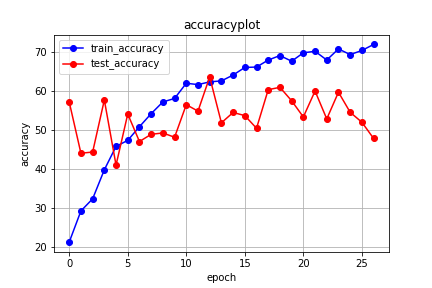

In [560]:
Image.open(exp_dir + '/' + 'accuracy' + '.png')

By observing the figure, the training accuracy keeps increasing, while the validation accuracy increases slightly. This, however, does not neccesirily mean that training isn't helpful, as we will see below that the model is gaining increase on f1-score. 

<a id='section_7.2'></a>

### 7.2 F1-Score

Below we show the f1-score in function of the training epochs.

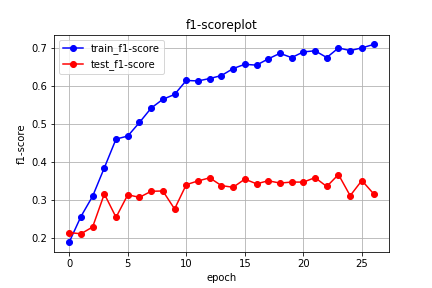

In [561]:
Image.open(exp_dir + '/' + 'f1-score' + '.png')

Different from the accuracy, our model cannot 'cheat' in getting a high f1-score as it does in the accuracy. Blindly estimating most samples to be 'Melanecytic nevi' will lead to a very low f1-score. With the training epochs increasing, the model is getting higher and higher f1-score value, which implies that our model is doing better in precision and recall. 

<a id='section_7.3'></a>

### 7.3 Cross Entropy Loss
The cross entropy loss as a function of the training epochs is shown as follows.

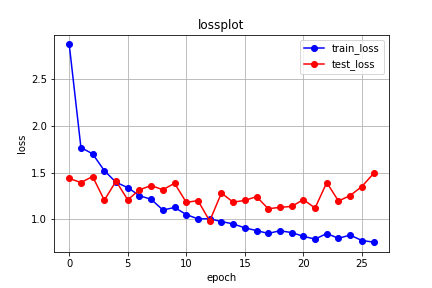

In [562]:
Image.open(exp_dir + '/' + 'loss' + '.png')

According to this figure, by observing the blue curve, the learning rate might be a bit low. It is worth trying a higher learning ratre to see if the loss could decrease more quicly in training. In addition, our model is sort of overfitting. To alleviate the problem further, **dropout layers** could be added to the neural network, after pooling layers as well as before the last linear layer. Though not shown here, we remark that data augmentation significantly helps dealing against the overfitting issue. Finally, we should consider **testing the model on larger dataset** (currently the split fraction for both training and testing is $0.1$), as by the figure above, the model is capable of learning the pattern for the current dataset (the loss keeps decreasing for training).

<a id='section_7.4'></a>

### 7.4 Confusion Matrix (Train)
For convinience, we also display the mapping between the class labels and their full names below.


In [563]:
display(class_names_pd)

,full name
class_names,
0,Actinic keratoses
1,Basal cell carcinoma
2,Benign keratosis-like lesions
3,Dermatofibroma
4,Melanoma
5,Melanocytic nevi
6,Vascular lesions


We show the confusion matrix for trainning as follows. The matrix is draw from the last epoch in our training. 

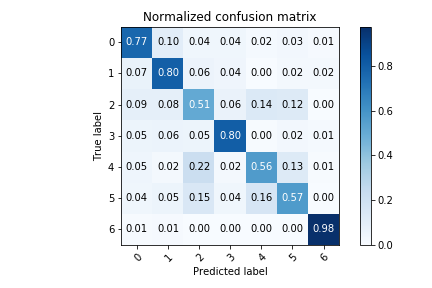

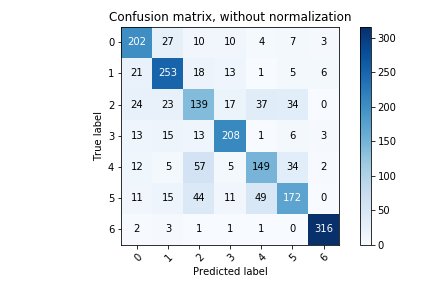

In [564]:
display(Image.open(exp_dir + '/' + 'train_conf_matrix_w_norm' + '.png'))
display(Image.open(exp_dir + '/' + 'train_conf_matrix_wo_norm' + '.png'))

By inspecting the matrix, we conclude that our model is able to learn the pattern from the image so as to do proper classification in general (the ideal case should be that all samples drops on the diagnal of the matrix). 

<a id='section_7.5'></a>

### 7.5 Confusion Matrix (Validation)
We show the confusion matrix for validation as follows. The matrix is drawn from the last epoch in our training.

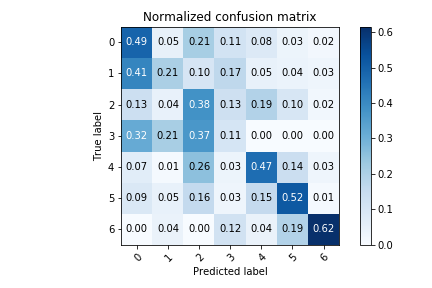

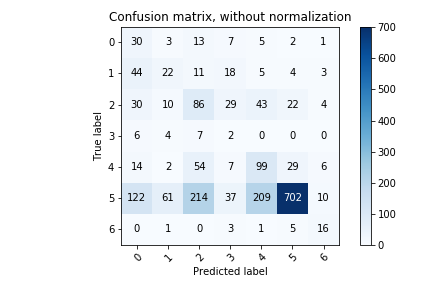

In [565]:
display(Image.open(exp_dir + '/' + 'test_conf_matrix_w_norm' + '.png'))
display(Image.open(exp_dir + '/' + 'test_conf_matrix_wo_norm' + '.png'))

By the confusion matrix, the accuracy of each class of our trained model, however, is not high enough. Our training is based on 

<a id='section_8'></a>

## 8 Conclusion and Findings
---
In this notebook, we have addressed the automated predictions of lesion diagnosis problem. is [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). The difficulty for applying deep learning on this dataset lies on the high imbalance of samples. Besides, the dataset is in general not large enough for deep learning models. To address these issues, we propose to use data augmentation, which is based on performing transformation on the images, so as to reproduce variances on the dataset. The data augmentation helps allievating the overfitting problem effectively. In addition, we have introduced weights for data samples with respect to their belonging classes. The weights are incorporated in the cross entropy loss function, as well as the weighted random sampling process during training, so as to handle the issue of dataset imbalance. 
We remark that some other metrics for model evaluation may also be useful here, e.g. the **area under the curve (AUC)** along with the **ROC** score.
We found that using more than two dropout layers may sometimes lead to severe underfitting for this problem, though we need more experiments to draw a solid conclusion. Finally, we remark that training the deep learning model for this problem on Colab is limited by the available GPU memory resource. Namely, setting the batch size to be larger than 10 may potentially cause the GPU memory running out quickly during training.